# Traversal order/methods
A key property of a tree data structure is the process of traversal, by which each Node is visited exactly once in a determined order. Traversal algorithms make it possible to calculate information on trees fast and efficiently, typically by performing calculations on parts of the tree which can be re-used in later calculations. Examples of this include summing branch lengths during traversal to measure distances between nodes, or the way in which Felsenstein's pruning algorithm calculates parsimony or likelihood scores while moving up a tree from tips towards the root. 

This section introduces different traversal algorithms, shows how they are implemented in `toytree`, and provides some demonstrations of how traversal can be used to write efficient functions. We also discuss the cached 'idxorder' traversal of `ToyTree` objects and show how this allows for fast and intuitive access to nodes in most situtations, as further demonstrated in the [Node Query/Selection section](/toytree/query/).

In [1]:
import toytree

In [2]:
# an example tree
tree = toytree.rtree.unittree(8, seed=123)

## Why traverse?
A `ToyTree` represents a container around a collection of connected `Node` objects. You can imagine that this collection of nodes could be stored in a variety of ways, such as a list or dictionary mapping names to nodes. But, either of these approaches would involve linearizing the node collection, rather than treating it hierarchically. And in each case, it would be necessary to choose the order in which to store the nodes, which raises the question of which order is the most useful, intuitive, or memorable. 

**A traversal algorithm represents a set of rules for consistently iterating over Nodes in a tree to visit each Node exactly once.** There are several common traversal algorithms designed to traverse trees, which we will cover shortly.

Different strategies have advantages in different scenarios, such as when calculating data for a child that depends on the state of its parent, or vice versa. Similarly, when performing a search process over a tree that can be terminated when a particular target is found, it is more efficient to use a traversal strategy that is more likely to encounter the target earlier. Most algorithms for computing statistics on trees, fitting evolutionary models to trees, or searching trees involves a traversal. Learning the most common traversal strategies is thus valuable towards understanding how these methods work, and for developing new tree-based methods.

The `traverse()` function of a `ToyTree` can be used to implement a tree traversal. This is a generator function, meaning it returns a generator that can be unpacked by iteration, and only generates each subsequent node in the traversal when requested. 

In [3]:
# traverse() is a generator function
tree.traverse(strategy="levelorder")

<generator object ToyTree.traverse at 0x7f13e4c1e1f0>

In [4]:
# unpacking the generator returns every Node visited once
list(tree.traverse("levelorder"))

[<Node(idx=14)>,
 <Node(idx=12)>,
 <Node(idx=13)>,
 <Node(idx=10)>,
 <Node(idx=11)>,
 <Node(idx=6, name='r6')>,
 <Node(idx=7, name='r7')>,
 <Node(idx=8)>,
 <Node(idx=9)>,
 <Node(idx=4, name='r4')>,
 <Node(idx=5, name='r5')>,
 <Node(idx=0, name='r0')>,
 <Node(idx=1, name='r1')>,
 <Node(idx=2, name='r2')>,
 <Node(idx=3, name='r3')>]

## Traversal strategies
Below I show the main traversal strategies in `toytree`: "levelorder", "preorder", "postorder", and "idxorder". Below is a custom function written to return a plot to visualize each traversal order shown as node labels on a tree. 

In [5]:
def get_traversal_drawing(tree: toytree.ToyTree, strategy: str) -> toytree.core.Canvas:
    """Return a tree drawing canvas showing a traversal strategy"""
    
    # create map of {node: int} in levelorder traversal
    order = {j: i for (i, j) in enumerate(tree.traverse(strategy))}
    
    # set as data to the tree
    tree.set_node_data(feature=strategy, data=order, inplace=True)
    
    # draw the tree showing the 'levelorder' feature on nodes
    c, a, m = tree.draw(layout='d', node_sizes=18, node_labels=strategy, node_mask=False);
    
    # add label
    a.label.text = f'"{strategy}" traversal'
    return c

### levelorder (root to tips)
A levelorder traversal (also called a breadth-first search; BFS) is an algorithm that starts at the root and visits all Nodes at a given depth descended from the root before moving to the next level. (Note: depth here refers to distance in number of nodes, not branch lengths). The Nodes in each level are visited in left to right order in toytree, but the opposite could just as easily be implemented. The primary utility of this traversal strategy is that it is topologically sorted, such that a parent is always visited before any of its children.

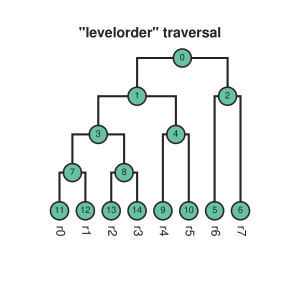

In [6]:
get_traversal_drawing(tree, "levelorder")

### preorder (root to tips)
A preorder traversal is an example of a [Depth-first search algorithm](https://en.wikipedia.org/wiki/Depth-first_search). It starts at the root Node and explores as far as possible along each descendant subtree before backtracking. The default in toytree is to visit the left subtree before the right subtree, such that the algorithm could be summarized as NLR (Node, left subtree, right subtree). The primary utility of this traversal strategy is that it is topologically sorted, such that a parent is always visited before any of its children. This property is also shared with levelorder traversal. The primary concern in distinguishing between these two strategies is if you plan to stop the traversal when a certain Node is found (e.g., to prevent having to traverse a very large set of Nodes), in which case the two will differ in the order in which they may find the stopping Node.

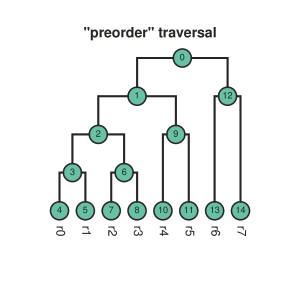

In [7]:
get_traversal_drawing(tree, "preorder")

### postorder (tips to root)
A *postorder* traversal is also a Depth-first search algorithm, similar to preorder traversal, however it yields nodes from this traversal very differently. It starts by traversing down the left subtree from the root until it reaches a tip Node (i.e., no more left subtrees descend from the current Node), it then checks for a right subtree (sister), and then visits the current Node. As with other algorithms, it could similarly be designed to visit right before left. Given the implementation in toytree, this algorithm could be summarized as LRN (left subtree, right subtree, Node). The primary utility of this traversal strategy is that it is topologically sorted, such that all children are always visited before their parent. This is especially useful for algorithms where parent values are calculated dependent on their child values. In a phylogenetic context, this involves algorithms for calculating likelihoods of data observed at the tips, for inferring ancestral state reconstructions, node depth/height calculations, and many more.

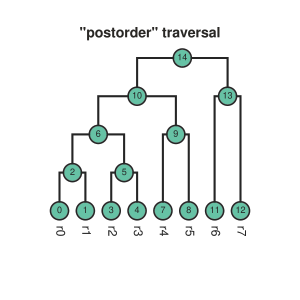

In [8]:
get_traversal_drawing(tree, "postorder")

### idxorder (tips to root)
This is a custom traversal order used by toytree. It could similarly be called "tips-first-then-postorder" traversal, because it works by first visiting the tip Nodes from left to right, and then proceeds by visiting internal nodes in a postorder manner (left then right subtrees, then their parent). This traversal strategy turns out be particularly convenient for working with phylogenetic trees, since the tip Nodes represent the actual extant samples in our dataset, and are therefore usually of greatest interest. This strategy is also topologically sorted, such that children are always visited before their parents.

This traversal thus makes it easier to select and find the tip Nodes by knowing that the first ntips Nodes in a tree will be the tips. This is not the case in any of the other tree traversal algorithms above.

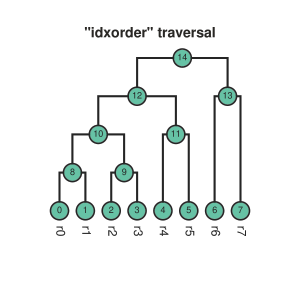

In [9]:
get_traversal_drawing(tree, "idxorder")

## Using a cached traversal
Although we just learned that tree traversal algorithms are widely useful for working with tree data structures, I am now going to going to argue a slightly contrary point, which is that, for the purpose of writing super-efficient code, you should try to limit the number of tree traversals that must be performed.

This is to say, if a tree isn't changed in some way (e.g., by modifying the topology or edge lengths), then a single tree traversal can be performed to cache the information about the tree structure (e.g., a specific traversal order), and any subsequent operations can make use of this cached information rather than traversing the entire tree again. This can make code run much faster since fetching information from a cache (e.g., a dictionary) is pretty much the fastest thing you can do in Python; much faster than traversing an entire tree. Of course, if the tree does change in some way (e.g., it is re-rooted) then a tree traversal will need to be performed to store the new structure and update the cached information again.

This is one of the key properties of the `ToyTree` class. It stores a cached representation of the 'idxorder' traversal of the nodes, and this cache is automatically updated when the tree structure is modified. This makes it easy to write functions that can access all or a subset of nodes, such as just the tips, or just the internal nodes, for quickly traverse all nodes in a postorder-type traversal. **This cache is the source of node "idx" labels**.

In [10]:
# node idx 0 represents the first node in an idxorder traversal
tree[3]

<Node(idx=3, name='r3')>

In [11]:
# node idx 10 represents the 11th node in an idxorder traversal
tree[10]

<Node(idx=10)>

### Speed Comparison
To make this point more clearly, let's walk through an example. Let's say that we want to access the names of every leaf Node in a tree. The two examples below compare selecting tip nodes from the cached idxorder versus performing a traversal of the entire tree. Both approaches are very fast, even on a large tree, but the cached traversal method is about 6X faster. This difference is not a big deal in this example, but it is good to be aware of, since some methods may require thousands of traversals over a tree.

In [12]:
bigtree = toytree.rtree.rtree(ntips=300)

In [13]:
%%timeit
# select tip nodes from the idxorder cache
[i.name for i in bigtree[:bigtree.ntips]]

40.5 µs ± 465 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%%timeit
# perform a new traversal to visit each node
names = []
for node in bigtree.traverse(strategy="idxorder"):
    if node.is_leaf():
        names.append(node.name)

352 µs ± 5.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Common traversals
Below are some common code snippets used to traverse all or parts of a tree:

### iterate over all nodes

In [15]:
# trees are iterable and return nodes in idxorder
for node in tree:
    pass

# same as above
for node in tree[:]:
    pass

# nodes can be indexed using their idxorder idx labels
for idx in range(tree.nnodes):
    node = tree[idx]

# to iterate idxorder in reverse (root to tips)
for node in tree[::-1]:
    pass

### iterate over leaf nodes
The strategies below can be used to traverse over leaf nodes (not internal nodes) efficiently.

In [16]:
# for tip nodes
for idx in range(tree.ntips):
    pass

# for tip nodes
for node in tree[:tree.ntips]:
    pass

# for tip nodes
for node in tree:
    if not node.is_leaf():
        pass

# tips in reverse order of how they will be plotted
for node in tree[:tree.ntips][::-1]:
    pass

# tips in reverse order of how they will be plotted
for node in tree[:tree.ntips:-1]:
    pass

### iterate over internal nodes
The strategies below can be used to traverse over internal nodes in a tree (not leaf nodes) efficiently.

In [17]:
# for internal nodes
for idx in range(tree.ntips, tree.nnodes):
    pass

# for internal nodes
for node in tree[tree.ntips: tree.nnodes]:
    pass

# for internal nodes
for node in tree[:]:
    if not node.is_leaf():
        pass

# for reverse order: root to last internal
for idx in range(tree.nnodes - 1, tree.ntips - 1, -1):
    node = tree[idx]

# for reverse order: root to last internal
for node in tree[tree.nnodes: tree.ntips:-1]:
    pass